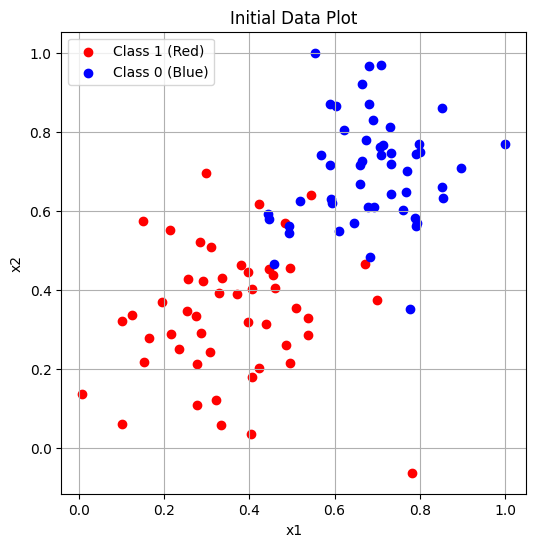

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("data.csv", header=None)
X = data.iloc[:, :2].values
y = data.iloc[:, 2].values

# Visualization of data
plt.figure(figsize=(6,6))
plt.scatter(X[y==1][:,0], X[y==1][:,1], color='red', label='Class 1 (Red)')
plt.scatter(X[y==0][:,0], X[y==0][:,1], color='blue', label='Class 0 (Blue)')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Initial Data Plot")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
data = pd.read_csv("data.csv", header=None)
print("Missing values per column:\n", data.isnull().sum())


Missing values per column:
 0    0
1    0
2    0
dtype: int64


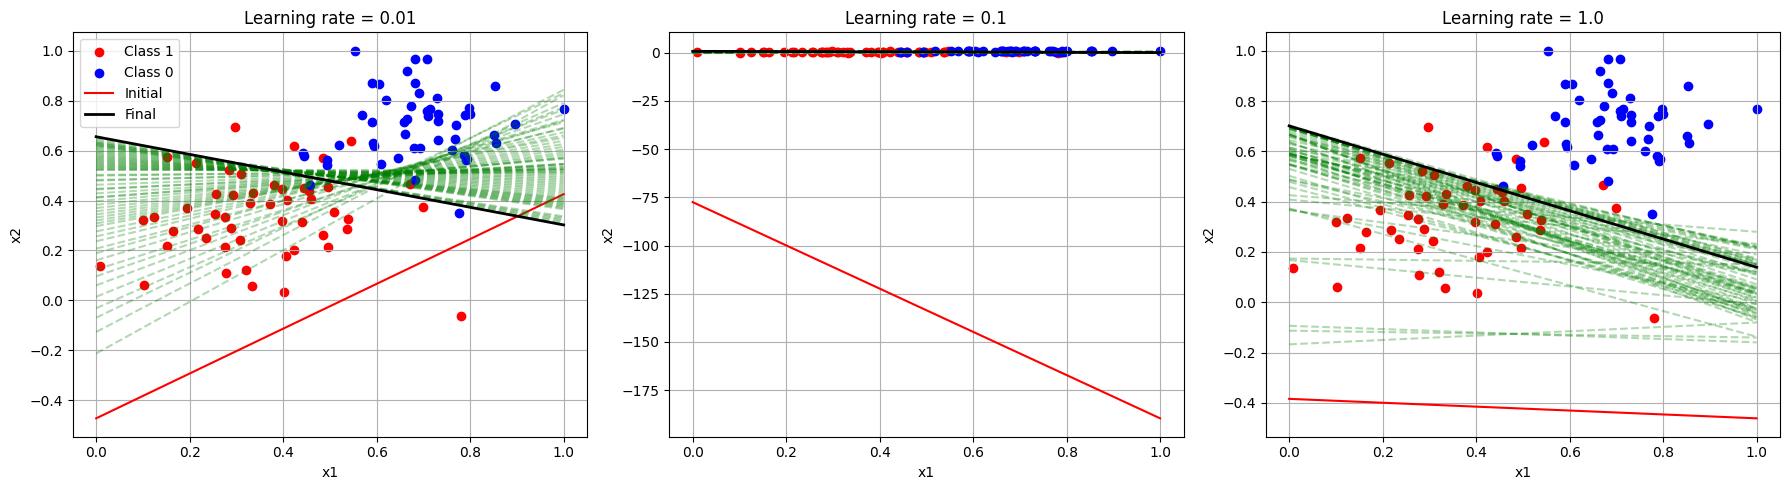

In [3]:
# Heuristic Perceptron function
def heuristic_perceptron(X, y, learning_rate=0.1, max_iter=65):
    n_samples, n_features = X.shape
    weights = np.random.randn(n_features)
    bias = np.random.randn()

    # store initial boundary
    boundaries = [(weights.copy(), bias)]

    def predict(x):
        return 1 if np.dot(weights, x) + bias >= 0 else 0

    for _ in range(max_iter):
        for idx, xi in enumerate(X):
            y_pred = predict(xi)
            error = y[idx] - y_pred

            if error == 1:
                weights += learning_rate * xi
                bias += learning_rate
            elif error == -1:
                weights -= learning_rate * xi
                bias -= learning_rate

        # boundary after this epoch
        boundaries.append((weights.copy(), bias))

    return weights, bias, boundaries


def plot_learning_rate_effects(X, y, learning_rates, max_iter=65):
    plt.figure(figsize=(6 * len(learning_rates), 5))

    for i, lr in enumerate(learning_rates):
        final_w, final_b, boundaries = heuristic_perceptron(
            X, y, learning_rate=lr, max_iter=max_iter
        )
        x_vals = np.linspace(0, 1, 100)

        plt.subplot(1, len(learning_rates), i + 1)

        # data points
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label="Class 1")
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label="Class 0")

        # Initial
        w, b = boundaries[0]
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, 'r-', label="Initial")

        # Intermediate
        for j in range(1, len(boundaries) - 1):
            w, b = boundaries[j]
            y_vals = -(w[0] * x_vals + b) / w[1]
            plt.plot(x_vals, y_vals, 'g--', alpha=0.3)

        # Final
        w, b = boundaries[-1]
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, 'k-', linewidth=2, label="Final")

        plt.title(f"Learning rate = {lr}")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.grid(True)
        if i == 0:
            plt.legend()

    plt.tight_layout()
    plt.show()


# run a few learning rates
plot_learning_rate_effects(X, y, learning_rates=[0.01, 0.1, 1.0], max_iter=65)


# Report
For the heuristic perceptron, the learning rate changed the behavior a lot.

With learning rate 0.01, the line moved slowly in small steps. It took many passes, but the line stayed stable and ended up in a reasonable place between the red and blue points.

With learning rate 0.1, the steps were too big. The line shot far away from the data and even went off the visible plot. The green lines between epochs jumped around a lot. This means the weights were blowing up and training was not stable.

With learning rate 1.0, the jumps were even bigger. The line kept moving in large jumps from epoch to epoch. It finishes with some separating line, but the path is messy and depends a lot on the random start.

So, for this heuristic model, 0.01 is the only safe learning rate. The larger learning rates (0.1 and 1.0) make the training unstable and are not good choices.




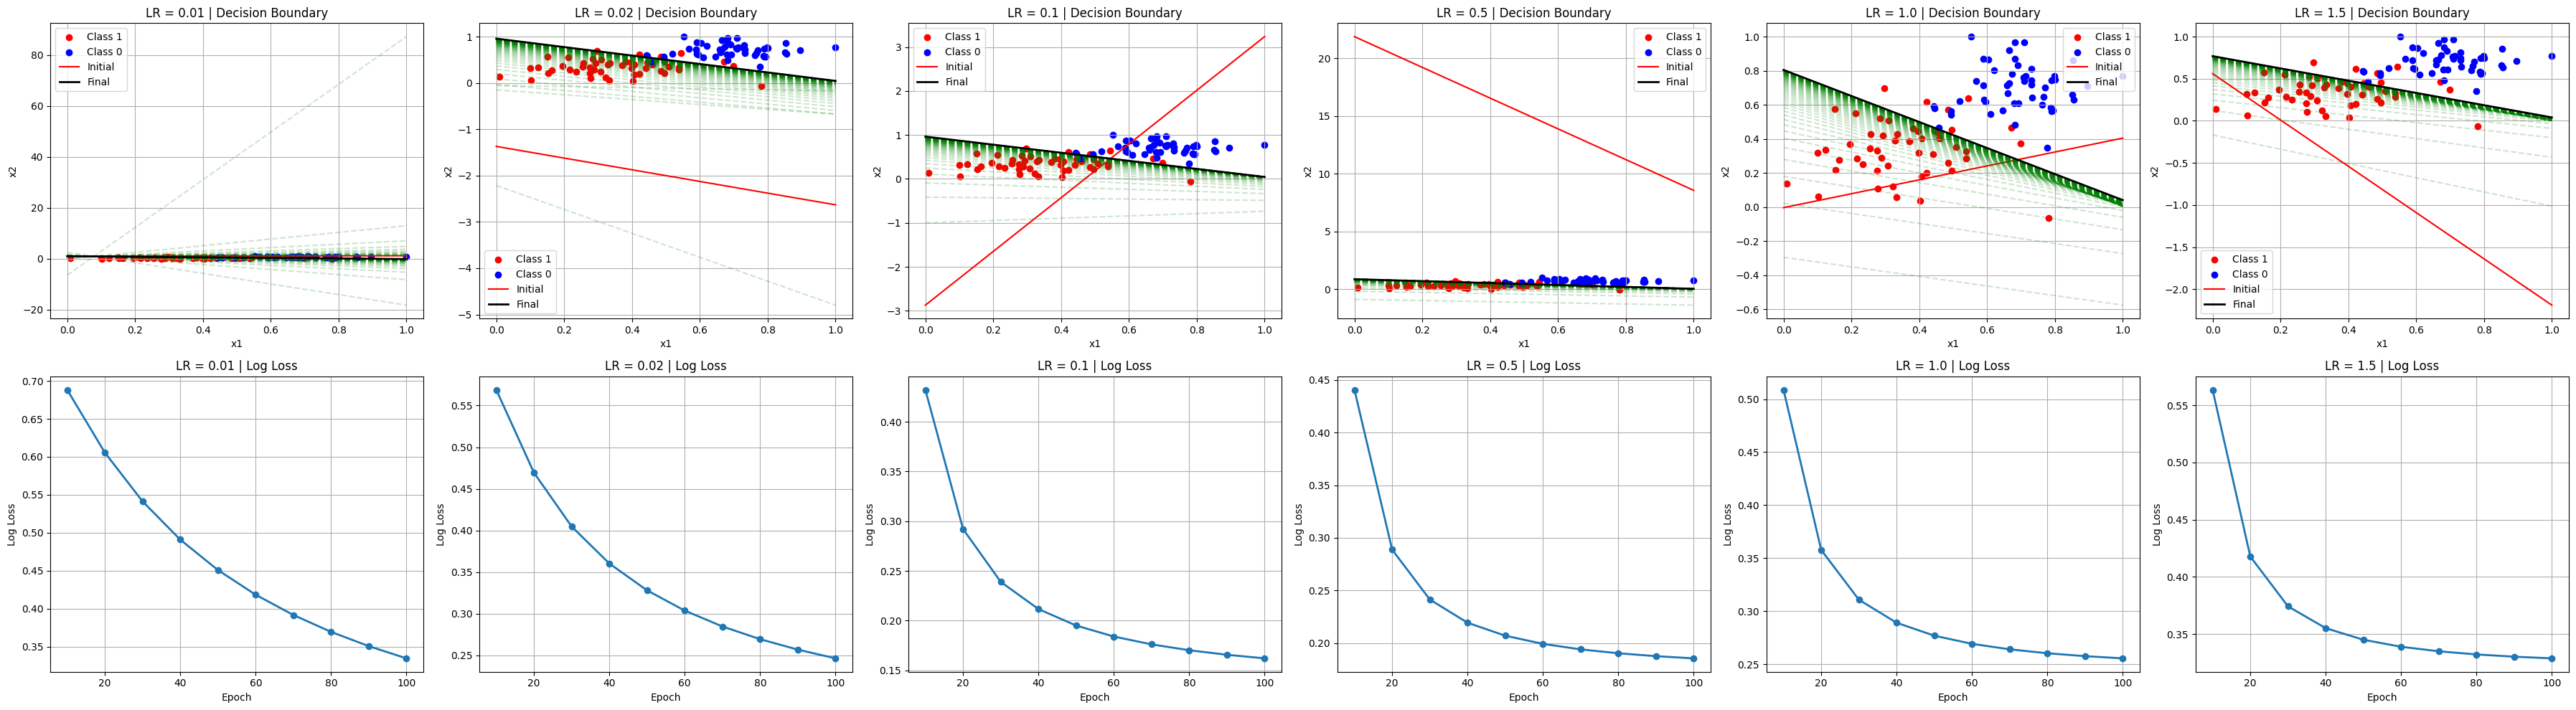

In [4]:
# Sigmoid and Log Loss
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def log_loss(y_true, y_pred):
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


# Gradient Descent Perceptron with true initial boundary + loss every 10 epochs
def gradient_descent_perceptron(X, y, learning_rate=0.1, epochs=100):
    n_samples, n_features = X.shape
    weights = np.random.randn(n_features)
    bias = np.random.randn()

    #store initial boundary (epoch 0)
    decision_boundaries = [(weights.copy(), bias)]
    losses = []
    loss_epochs = []

    for epoch in range(epochs):
        for idx in range(n_samples):
            xi = X[idx]
            yi = y[idx]
            z = np.dot(weights, xi) + bias
            y_hat = sigmoid(z)
            error = yi - y_hat

            # gradient-style update
            weights += learning_rate * error * xi
            bias += learning_rate * error

        # boundary after this epoch
        decision_boundaries.append((weights.copy(), bias))

        # log loss after 100 epochs
        if (epoch + 1) % 10 == 0:
            y_preds = sigmoid(np.dot(X, weights) + bias)
            losses.append(log_loss(y, y_preds))
            loss_epochs.append(epoch + 1)

    return weights, bias, decision_boundaries, losses, loss_epochs


def run_part2_multiple_rates(X, y, learning_rates=[0.01, 0.1, 1.0], epochs=100):
    fig, axs = plt.subplots(2, len(learning_rates), figsize=(6 * len(learning_rates), 10))

    for i, lr in enumerate(learning_rates):
        final_w, final_b, boundaries, losses, loss_epochs = gradient_descent_perceptron(
            X, y, learning_rate=lr, epochs=epochs
        )
        x_vals = np.linspace(0, 1, 100)

        #  Decision boundaries
        axs[0, i].scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
        axs[0, i].scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')

        # TRUE initial line
        w, b = boundaries[0]
        y_vals = -(w[0] * x_vals + b) / w[1]
        axs[0, i].plot(x_vals, y_vals, 'r-', label='Initial')

        # Intermediate
        for j in range(1, len(boundaries) - 1):
            w, b = boundaries[j]
            y_vals = -(w[0] * x_vals + b) / w[1]
            axs[0, i].plot(x_vals, y_vals, 'g--', alpha=0.2)

        # Final
        w, b = boundaries[-1]
        y_vals = -(w[0] * x_vals + b) / w[1]
        axs[0, i].plot(x_vals, y_vals, 'k-', linewidth=2, label='Final')

        axs[0, i].set_title(f"LR = {lr} | Decision Boundary")
        axs[0, i].set_xlabel("x1")
        axs[0, i].set_ylabel("x2")
        axs[0, i].grid(True)
        axs[0, i].legend()

        #Log Loss every 10 epoch
        axs[1, i].plot(loss_epochs, losses, linewidth=2, marker='o')
        axs[1, i].set_title(f"LR = {lr} | Log Loss")
        axs[1, i].set_xlabel("Epoch")
        axs[1, i].set_ylabel("Log Loss")
        axs[1, i].grid(True)

    plt.tight_layout()
    plt.show()


# Run for all learning rates
run_part2_multiple_rates(
    X, y,
    learning_rates=[0.01, 0.02, 0.1, 0.5, 1.0, 1.5],
    epochs=100
)


# **REPORT**
This section investigates how different learning rates affect the performance and convergence of the gradient-descent perceptron. The model was trained for 100 epochs on the same binary classification task as in Part 1. For each learning rate, I looked at the decision boundary over time and the log-loss every 10 epochs.

I tested learning rates 0.01, 0.02, 0.1, 0.5, 1.0, and 1.5.


LR = 0.01

The model updated the weights in very small increments, leading to slow but very stable convergence.
The decision boundary shifted gradually from the random initialization and eventually produced a reasonable separation between the two classes.
The log-loss curve showed a smooth, steady decline throughout training.
This rate is safe but inefficient; it wastes epochs making tiny improvements.

LR = 0.02

This learning rate preserved the stability of 0.01 while improving the speed of convergence.
The decision boundary adjusted more noticeably each epoch, reaching a good separator earlier.
The log-loss decreased more rapidly and reached a similar final value with fewer effective updates.
Overall,N= 0.02
 offers a strong balance between caution and progress and would be a solid default for similar datasets.

LR = 0.1

This setting gave the best overall behavior.
The model converged quickly: the decision boundary moved into a good position within the first few dozen epochs and then only fine-tuned.
The log-loss dropped sharply early in training and then flattened  which is exactly the pattern we want (fast learning followed by stabilization).

LR = 0.5, 1.0, 1.5

For the higher learning rates, several common trends appeared like
The early updates were very aggressive, causing large changes in the decision boundary between epochs.
The log-loss still decreased and reached low values, but the curves were less smooth than for 0.1 or 0.02.
The final boundaries were similar in quality to those from
n=0.1, meaning there was no real performance gain despite the more updates.
These rates push the algorithm close to its stability limit: training remains convergent on this dataset, but becomes more sensitive to initialization and data ordering, with no clear improvement over
n=0.1 or n=0.02. They are usable, but not preferable.

# **Comparing the models**

In the heuristic perceptron, the only learning rate that worked well on this dataset was 0.01. With this small step size, the decision boundary moved slowly but stayed stable and ended up separating the classes reasonably well. When I increased the learning rate to 0.1 and 1.0, the updates became too big. The decision boundary jumped off the visible region of the plot, and the lines between epochs moved around a lot. This shows the weights were blowing up and the training was unstable.

The gradient-descent perceptron (with sigmoid and log-loss) behaved much better. For all learning rates between 0.01 and 1.5, the log-loss went down over time and the final decision boundary made sense. A learning rate of 0.1 gave the fastest and smoothest training.

At learning rate 0.1, the difference between the two methods is clear:
the heuristic version is unstable, but the gradient-descent version converges quickly and we can clearly see its progress from the loss curve. In short, the heuristic perceptron is simple but very sensitive to the learning rate, while the gradient-descent perceptron is easier to tune and more reliable on this problem.

# conclusion

the experiments show that the heuristic perceptron is very sensitive to the learning rate. It only worked well with a small rate (0.01); larger rates made the updates explode and the decision boundary unstable. The gradient-descent perceptron with sigmoid and log-loss handled a much wider range of learning rates (0.01 - 1.5) and trained smoothly, with 0.1 giving the best balance of speed and stability. For this dataset, gradient descent is clearly the more reliable and practical way to train a perceptron.

